# Car ownership calibration 

In [3]:
import numpy as np 
import pandas as pd 
import time
import orca 
# import matplotlib.pyplot as plt
import seaborn as sns
# import sklearn 

# from sklearn.model_selection import KFold, train_test_split
# from statsmodels.discrete.discrete_model import MNLogit

In [4]:
from platform import python_version

print(python_version())

3.9.2


In [24]:
hdf = pd.HDFStore('output/pipeline.h5')
# pp = hdf['/persons']
hh = hdf['/households/trip_mode_choice']
# tours = hdf['/tours']
# trips = hdf['/trips/trip_mode_choice']
acc = hdf['/accessibility/trip_mode_choice']
lu = hdf['/land_use/trip_mode_choice']

# print ('Number of Households: ',hh.shape[0])
# print ('Number of Persons: ',pp.shape[0])
# print ('Number of tours: ',tours.shape[0])
# print ('Number of trips: ',trips.shape[0])

# Add VEHICL variable form USIM tables 
# Problem is that new household tables does not output 
#all the variables that i put as INPUT But rather some selected columns 
# VEHICL columns is dropped from the output files. 
# Since i calubrate with this data, I take it directly form U_sim data 
# hh_usim = pd.read_csv('data/households.csv').set_index('household_id')
# hh = hh.merge(hh_usim[['VEHICL']], left_index=True, right_index=True, how = 'inner')

In [26]:
def simulation(probs):
    """
    Runs a Monte Carlo simulation given a probability distribution. 
    Input: 
    - probs: Array-like of probability distributions. 
             Each row is a different individual, 
             each column is possible choice. 
             
    Returns: Final choice. 
    
    Example input file: 
    
    ID.  CAR_0  CAR_1  CAR_2 
    1.    0.5    0.2    0.3
    2.    0.3    0.5    0.2
    """
    rands = np.random.rand(len(probs),1,)
    probs_arr = probs.values.cumsum(axis=1) - rands
    choices = np.argmax(probs_arr > 0.0, axis=1)
    choices = pd.Series(choices, index=probs.index)
    return choices

In [27]:
def run_car_ownership(values, coeffs):
    """
    Returns auto_ownership choice 
    1. Evaluate utilities 
    2. Calculate probabilities 
    3. Make choices (with simulation function)
    
    Input: 
    - Values: Attributes of the individaul 
    - Coeffs: Estimated coefficients in model specification
    
    Return: 
    - Final car ownership choice for each individual
    """
    utils = (values @ coeffs).astype(float)
    utils_exp = utils.apply(np.exp)
    probs = utils_exp.div(utils_exp.sum(axis = 1), axis = 0)
    choices = simulation(probs)
    return choices

In [28]:
def car_ownership_validation(hh):
    ''' 
    Validation tool for car ownership model. 
    Input: Dataframe with columns VEHCL: Real number of vehicles, 
           and 'auto_ownership': predicted household car ownership. 
    Output: Plots of carownership by TAZ, 
            and table with cars(real value), 
            auto ownership(modeled value), 
            and the difference. 
    '''
    # Auto ownership by TAZ 
    hh['0'] = hh['auto_ownership'] == 0
    hh['1'] = hh['auto_ownership'] == 1
    hh['2'] = hh['auto_ownership'] == 2
    hh['3'] = hh['auto_ownership'] == 3
    hh['4'] = hh['auto_ownership'] == 4

    auto_asim = hh.groupby('TAZ').agg({'0': 'sum','1': 'sum','2': 'sum','3': 'sum','4': 'sum' })
    auto_asim.reset_index(inplace = True)

    auto_asim = pd.melt(auto_asim, id_vars=['TAZ'], value_vars=['0', '1', '2', '3', '4'])
    
    #VEHCL by TAZ 
    hh['0'] = hh['cars'] == 0
    hh['1'] = hh['cars'] == 1
    hh['2'] = hh['cars'] == 2
    hh['3'] = hh['cars'] == 3
    hh['4'] = hh['cars'] >= 4

    auto_tm1 = hh.groupby('TAZ').agg({'0': 'sum','1': 'sum','2': 'sum','3': 'sum','4': 'sum', })
    auto_tm1.reset_index(inplace = True)

    auto_tm1 = pd.melt(auto_tm1, id_vars=['TAZ'], value_vars=['0', '1', '2', '3', '4'])
    
    # Merge ativitysim and validation results in one table
    auto = auto_asim.merge(auto_tm1, how = 'inner', on = ['TAZ', 'variable'], suffixes=('_asim', '_tm1'))
    auto.columns = ['TAZ', 'Auto ownership', 'ActivitySim', 'True value']
    
    #Plot
    g = sns.lmplot('True value','ActivitySim', auto,col = 'Auto ownership',sharex = False,sharey = False,
               markers='o', height=5, aspect=0.8, x_jitter=.1, col_wrap=3,
              scatter_kws={"s": 20, "edgecolor": 'k', "alpha": 0.5})

    g.fig.suptitle("H3-to-H3 Car ownerwhip \n ActivitySim", y=1.05, fontsize = 15);

In [29]:
def add_simulation_vars(households, accessibilities, land_use):
    """
    Generate dataframe with the variables that are needed for simulation according to the model specification. 
    Input: 
    - Households: DataFrame with household table (Simulation resuls)
    - accessibilities: DataFrame. Accessibilities table (Simulation Result)
    - land_use: DataFrame. Land use table (Simulation result)
    
    Output: 
    - Dataframe with needed variables to simulate the car ownership model. 
    """
    #Merge accesibilities and land use variables 
    hh_merge = hh.merge(accessibilities, how = 'inner', left_on = 'TAZ', right_index = True).\
              merge(land_use, how = 'inner', left_on = 'TAZ', right_index = True)
    
    #Household-based variables 
    hh_merge['util_drivers_2'] = hh_merge.num_drivers == 2
    hh_merge['util_drivers_3'] = hh_merge.num_drivers == 3
    hh_merge['util_drivers_4_up'] = hh_merge.num_drivers > 3
    hh_merge['util_persons_16_17'] = hh_merge.num_children_16_to_17
    hh_merge['util_persons_18_24'] = hh_merge.num_college_age #College
    hh_merge['util_persons_25_34'] = hh_merge.num_young_adults #Young adults
    hh_merge['util_presence_children_0_4'] = hh_merge.num_young_children > 0
    hh_merge['util_presence_children_5_17'] = (hh_merge.num_children_5_to_15 + hh_merge.num_children_16_to_17)>0
    hh_merge['util_num_workers_clip_3'] = hh_merge.num_workers.clip(upper = 3)
    hh_merge['util_hh_income_0_30k'] = hh_merge.income_in_thousands.clip(0,30)
    hh_merge['util_hh_income_30_75k'] = (hh_merge.income_in_thousands-30).clip(0,45)
    hh_merge['util_hh_income_75k_up'] = (hh_merge.income_in_thousands-75).clip(0,50)
    
    #Household and land_use-based variables 
    hh_merge['util_density_0_10_no_workers'] = (hh_merge.num_workers == 0)*(hh_merge.density_index.clip(0,10))
    hh_merge['util_density_10_up_no_workers'] = (hh_merge.num_workers == 0)*(hh_merge.density_index-10).clip(0)
    hh_merge['util_density_0_10_workers'] = (hh_merge.num_workers > 0)*(hh_merge.density_index.clip(0,10))
    hh_merge['util_density_10_up_workers'] = (hh_merge.num_workers > 0)*(hh_merge.density_index-10).clip(0)
    
    #ASC
    hh_merge['util_asc'] = 1
    hh_merge['util_asc_san_francisco'] = 0   
    hh_merge['util_asc_solano'] = 0 
    hh_merge['util_asc_napa'] = 0 
    hh_merge['util_asc_sonoma'] = 0 
    hh_merge['util_asc_marin'] = 0 
    
    #Accessibility_based variables
    hh_merge['util_retail_auto_no_workers'] = (hh_merge.num_workers == 0)*(0.66*hh_merge.auPkRetail + 0.34*hh_merge.auOpRetail)
    hh_merge['util_retail_auto_workers'] = (hh_merge.num_workers > 0)*(0.66*hh_merge.auPkRetail + 0.34*hh_merge.auOpRetail)
    hh_merge['util_retail_transit_no_workers'] = (hh_merge.num_workers == 0)*(0.66*hh_merge.trPkRetail + 0.34*hh_merge.trOpRetail)
    hh_merge['util_retail_transit_workers'] = (hh_merge.num_workers > 0)*(0.66*hh_merge.trPkRetail + 0.34*hh_merge.trOpRetail)
    hh_merge['util_retail_non_motor_no_workers'] = (hh_merge.num_workers == 0)*hh_merge.nmRetail
    hh_merge['util_retail_non_motor_workers'] = (hh_merge.num_workers > 0)*hh_merge.nmRetail
    hh_merge['util_auto_time_saving_per_worker'] = np.where(hh_merge.num_workers > 0, 
                                      hh_merge.hh_work_auto_savings_ratio/hh_merge.num_workers, 
                                      0)
    
    hh_merge['cars'] = hh_merge.VEHICL.where(hh_merge.VEHICL < 4, 4)
    return hh_merge

In [30]:
def create_random_sample_from_grid(grid, size = 100):
    ''' Returns a dictionary with len size of random draws from the grid. 
    Input:
    grid: Dict. 
    size = Number of random draws
    '''
    sample_dict = dict()
    for var in grid:
        sample_dict[var] = np.random.choice(grid[var], size, replace = True)
    grid_rands = pd.DataFrame(sample_dict).to_dict('index')
    return grid_rands

In [31]:
def grid_search(grid, specs_csv, coeffs_dict, hh_merge,  iterations = 50): #var_names
    '''
    Grid-like search algortihm to estimate the best parameters to maximize prediction of car ownership share
    Input: 
    - var_to_replace: list of 12 arrays. Each array contains the range for each coefficient. 
                    List in the following order: 
                    0. Constant 1_car
                    1. Constant 2_car
                    2. Constant 3_car
                    3. Constant 4_car
                    4. driver_2 1_car
                    5. driver_2 2_car
                    6. driver_2 3_car
                    7. driver_2 4_car
                    8. driver_3 1_car
                    9. driver_3 2_car
                    10. driver_3 3_car
                    11. driver_3 4_car
    - coeff: The coefficients dataframe
    - hh_merge: choosers
    - var_name: should be coefficient indexes and all var should be in hh_merge (not needed anymore)
    - iteration: Number of random sets for the gris like-search (since there are a lot of options,I select some of them)
    
    Return 
    Dataframe with "iterations" amount of rows.
    Each row represents the result of one combination of the 12 varaibles, and the corresponding score. 
    '''

    random_grid = create_random_sample_from_grid(grid, size = iterations)
    assert iterations == len(random_grid)
    score_list = []
    #Run iterations 
    for x in random_grid:
        # Replace random coeffs 
        coeffs = specs_csv.replace(random_grid[x])

        # Replaces non-changing coeffs 
        coeffs = coeffs.replace(coeffs_dict)

        # formating for simulation 
        coeffs = coeffs.drop(columns = ['Description', 'Expression']).fillna(0)
        
        # Run model 
        choices = run_car_ownership(hh_merge[coeffs.index], coeffs)
        hh_merge['auto_ownership'] = choices 
        
        ## Loss Function
#         score = np.abs((hh_merge.cars.value_counts() -  hh_merge.auto_ownership.value_counts())).sum()
#         score = np.sqrt(((hh_merge.cars -  hh_merge.auto_ownership)**2).mean())
        score = mse(hh_merge.cars, hh_merge.auto_ownership )
        score_list.append(score)

    
    results_join = pd.DataFrame.from_dict(random_grid, orient = 'index' )
    results_join['score'] = score_list
    
    return results_join

In [32]:
def mse(target, predicted):
    error = target - predicted
    squared_error = error**2
#     score = np.mean(squared_error)
    score = np.abs((target.value_counts() -  predicted.value_counts())).sum()
    
    return score

In [33]:
def initialize_grid(coeffs_dict, calibrate, percentage):
    grid = dict()
    for variable in calibrate:
        min_value = coeffs_dict[variable] * (1 - percentage)
        max_value = coeffs_dict[variable] * (1 + percentage)
        grid[variable] = np.linspace(min_value, max_value, 11)
    return grid 

In [34]:
def grid_search_iterations(hh_merge, calibrate, percentage, tolerance = 0.01, iterations = 50):
    """ Returns the best coefficients based on a grid search 
        and a updated hh_merge with the simulated car_ownership
        with the new best coefficients 
        
        Input: 
        - hh_merge: Pandas DataFrame: Data
        - tolerance: stoping point for the grid_search update. 
        - iterations: Iterations for each grid search. 
        """
    
    last_score, good_score, iter_num = 9999999, 1, 0
    
    specs_csv, coeffs = car_ownership_specs()
    grids = initialize_grid(coeffs, calibrate, percentage)
    assert len(grids) == len(calibrate)
    #Run the iterations 
    
    while good_score > tolerance : 
        print(f"ITERATION: {iter_num}")
        #Run grid search 
        start = time.time()
        grid_results = grid_search(grids, specs_csv, coeffs, hh_merge, iterations)
        end = time.time()
        print(f"Runtime of the program is {end - start} seconds")

        #Get best score
        min_score = grid_results.score.min()
        print(f" Best score is: {min_score}")
        
        if min_score > last_score:
            grids = grids 
#             good_score = np.abs((last_score - min_score)/last_score)
            print(f"Bad restuls. Take previous grid")
        else: 

        #Evalute best score reduction 
            good_score = np.abs((last_score - min_score)/last_score)
            print(f"The score reduction is: {good_score}%")
            #Update variables intervals
            grids = new_grid_ranges(grid_results)

        #Replace last_score value
        last_score = min_score
        iter_num = iter_num + 1
        print ("")
    
#     #TO ASK: Should I get the coefficients with the min score, 
#     #or an average of the top10 (or more) coefficients. 
    best_coeffs = grid_results[grid_results.score == grid_results.score.min()]
    new_coeffs = save_new_specs(best_coeffs)
    return new_coeffs

In [35]:
def car_ownership_specs():
    """ Reads the specification for the auto ownership model"""
    # Read csv file 
    specs_csv = pd.read_csv('configs/configs/auto_ownership.csv').set_index('Label')
    coeffs_csv = pd.read_csv('configs/configs/auto_ownership_coeffs.csv').set_index('coefficient_name')
    
    coeffs_dict = coeffs_csv['value'].to_dict()
    return specs_csv, coeffs_dict

In [36]:
def initialize_grid(coeffs_dict, calibrate, percentage):
    grid = dict()
    for variable in calibrate:
        min_value = -5 #coeffs_dict[variable] * (1 - percentage)
        max_value = 5  #coeffs_dict[variable] * (1 + percentage)
        grid[variable] = np.linspace(min_value, max_value, 11)
    return grid 

In [37]:
def create_random_sample_from_grid(grid, size = 100):
    ''' Returns a dictionary with len size of random draws from the grid. 
    Input:
    grid: Dict. 
    size = Number of random draws
    '''
    sample_dict = dict()
    for var in grid:
        sample_dict[var] = np.random.choice(grid[var], size, replace = True)
    grid_rands = pd.DataFrame(sample_dict).to_dict('index')
    return grid_rands

In [38]:
def new_grid_ranges(grid_results):
    """ 
    Updates the new ranges for each variable for the next set of iterations
    Input: 
    - grid_results: Result table of the previous iteration (This table is generated by "grid_results" function)
    
    Output:
    - Array with the varaibles new grids values. 
    """
    
    #Order results from min to max score (we just want the 10th best scores for this)
    ordered = grid_results.sort_values('score').head(10)
    ordered = ordered.drop(columns = 'score')
    
    dict_ = dict()
    for x in ordered.iteritems():
        min_ = x[1].min()
        max_ = x[1].max()
        dict_[x[0]] = np.linspace(min_,max_,11)
    
    return dict_

In [39]:
def save_new_specs(new_coeffs):
    
    coeffs_csv = pd.read_csv('configs/configs/auto_ownership_coeffs.csv').set_index('coefficient_name')
    new_coeffs = new_coeffs.drop(columns = 'score').reset_index(drop = True).to_dict('index')[0]
    
    for var_name in new_coeffs:
        coeffs_csv.at[var_name, 'value'] = new_coeffs[var_name]
        
    print ('Saving new coeffs in configs')
    coeffs_csv.to_csv('configs/auto_ownership_coeffs.csv')
    return new_coeffs

## Run Clibration 

In [57]:
#Variables to calibrate
calibrate = ['coef_cars1_asc', 'coef_cars2_asc', 'coef_cars3_asc', 'coef_cars4_asc']
percentage = 0.3
hh_merge = add_simulation_vars(hh, acc, lu).sample(5000)

In [58]:
%%time
best_coefss = grid_search_iterations(hh_merge, calibrate, percentage, tolerance = 0.01, iterations = 100)

ITERATION: 0
Runtime of the program is 4.732346296310425 seconds
 Best score is: 1654.0
The score reduction is: 0.99983459998346%

ITERATION: 1
Runtime of the program is 4.739252328872681 seconds
 Best score is: 1070.0
The score reduction is: 0.35308343409915355%

ITERATION: 2
Runtime of the program is 4.738736391067505 seconds
 Best score is: 1250.0
Bad restuls. Take previous grid

ITERATION: 3
Runtime of the program is 4.746327638626099 seconds
 Best score is: 908.0
The score reduction is: 0.2736%

ITERATION: 4
Runtime of the program is 4.7423484325408936 seconds
 Best score is: 838.0
The score reduction is: 0.07709251101321586%

ITERATION: 5
Runtime of the program is 4.742643117904663 seconds
 Best score is: 406.0
The score reduction is: 0.5155131264916468%

ITERATION: 6
Runtime of the program is 4.718209981918335 seconds
 Best score is: 154
The score reduction is: 0.6206896551724138%

ITERATION: 7
Runtime of the program is 4.715336799621582 seconds
 Best score is: 230
Bad restuls. 

In [59]:
best_coefss

{'coef_cars1_asc': 4.8600219430400005,
 'coef_cars2_asc': 2.3460211584,
 'coef_cars3_asc': 0.22072142105599973,
 'coef_cars4_asc': -1.49424765196288}

## Run validation 

In [60]:
def get_coeffs(specs, old_coeffs, best_coeffs):
    coeffs = specs.replace(best_coeffs)
    coeffs = coeffs.replace(old_coeffs)
    coeffs = coeffs.drop(columns = ['Description', 'Expression']).fillna(0)
    return coeffs

In [61]:
def validation_toll(table, target, predicted):
    
    
    
    
    toplot = table.groupby('TAZ').agg({target:'value_counts',
                                  predicted:'value_counts'}).reset_index()
    
    toplot.rename(columns = {'level_0':'TAZ', 'level_1':'Auto ownersip', 
                        target:'target', predicted: 'predicted'}, inplace = True )
    
    g = sns.lmplot('target','predicted', toplot, col = 'Auto ownersip',sharex = False,sharey = False,
               markers='o', height=5, aspect=0.8, x_jitter=.1, col_wrap=3,
              scatter_kws={"s": 20, "edgecolor": 'k', "alpha": 0.5})


/home/ubuntu/anaconda3/envs/asim/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


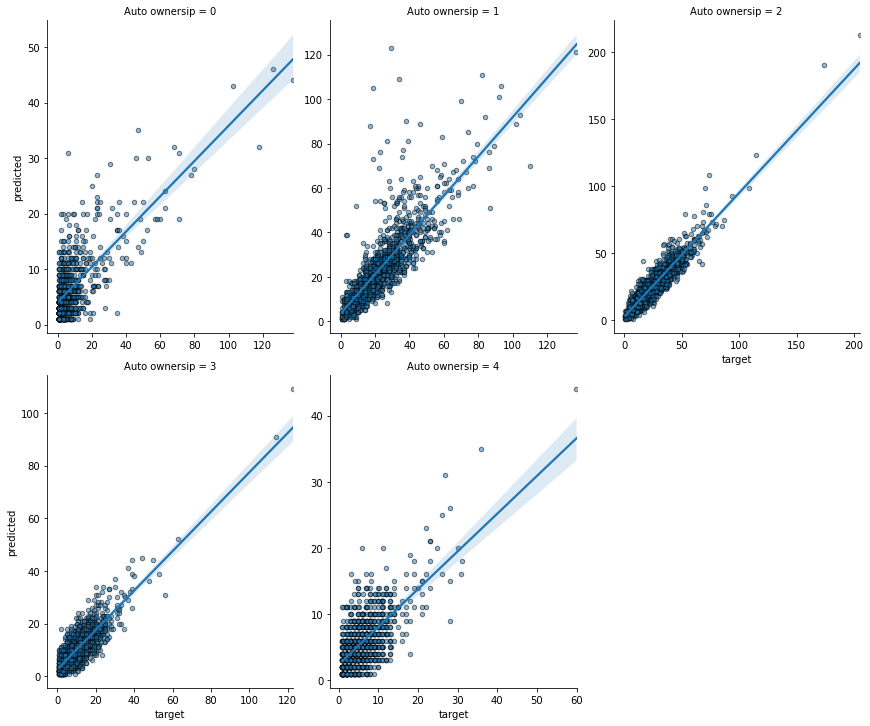

In [62]:
## Aggregate calibration 
specs, coeffs = car_ownership_specs()
hh_merge = add_simulation_vars(hh, acc, lu)
coeff_final = get_coeffs(specs, coeffs, best_coefss)
choices = run_car_ownership(hh_merge[coeff_final.index], coeff_final)
hh_merge['cars_predicted'] = choices 
validation_toll(hh_merge, 'cars', 'cars_predicted')

In [63]:
hh_merge.cars_predicted.mean()

1.82257

In [64]:
hh_merge.cars.mean()

1.81188

In [65]:
hh_merge.auto_ownership.mean()

1.1867